In [3]:
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,Activation,AvgPool2D,MaxPool2D,GlobalAvgPool2D
from tensorflow.keras import models
# from src.data.generators import create
from tensorflow import keras
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:
# ! pip install split-folders
import splitfolders
splitfolders.ratio('data', output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [4]:
train_path = "output\\train"
test_path = "output\\test"
valid_path = "output\\val"

batch_size = 16
img_height, img_width = (256, 256)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 11045 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.


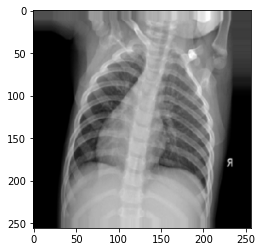

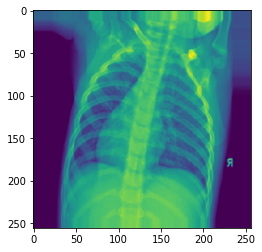

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# import cv2
for i,j in train:
  img = i[0]
  plt.imshow(np.squeeze(img),cmap ='gray')
  plt.show()
  plt.imshow(np.squeeze(img))
  plt.show()
  break
# plt.show()

In [7]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [8]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [9]:
#Uncomment the following if running on colab

# from tensorflow.keras.utils import plot_model
# plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [11]:
type(train.classes)

numpy.ndarray

In [12]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight = "balanced",classes = np.unique(train.classes),y = train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9095781466113417, 1: 0.6773580277198578}


In [ ]:
cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
# # !mkdir model
# model_path = "/content/model/Covid_CNN.h5"
# drive_path = "/content/drive/MyDrive/Colab Notebooks/Covid_CNN.h5"
# cnn.save(model_path)
# cnn.save(drive_path)

In [13]:
model_path = "model\\Covid_CNN.h5"
model =load_model(model_path)
# model.predict_segmentation()
# pd.DataFrame(model.history.history).plot()
# cnn.summary()

In [17]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
print('The testing loss is :',test_accu[0])

87/87 [==============================] - 9s 101ms/step - loss: 0.0700 - accuracy: 0.9798
The testing accuracy is : 97.97541499137878 %
The testing loss is : 0.07001542299985886


In [20]:
preds = model.predict(test,verbose=1)

87/87 [==============================] - 10s 110ms/step


In [21]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

predictions

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

<AxesSubplot:>

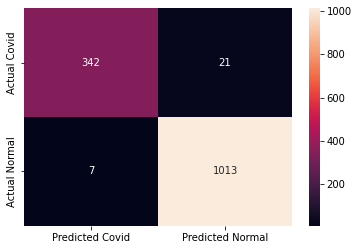

In [22]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Covid", "Actual Normal"],
                  columns=["Predicted Covid", "Predicted Normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [23]:
print(classification_report(y_true=test.classes, y_pred=predictions,target_names =['COVID','NORMAL']))

              precision    recall  f1-score   support

       COVID       0.98      0.94      0.96       363
      NORMAL       0.98      0.99      0.99      1020

    accuracy                           0.98      1383
   macro avg       0.98      0.97      0.97      1383
weighted avg       0.98      0.98      0.98      1383



In [24]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape,y.shape)

(1383, 256, 256, 1) (1383,)


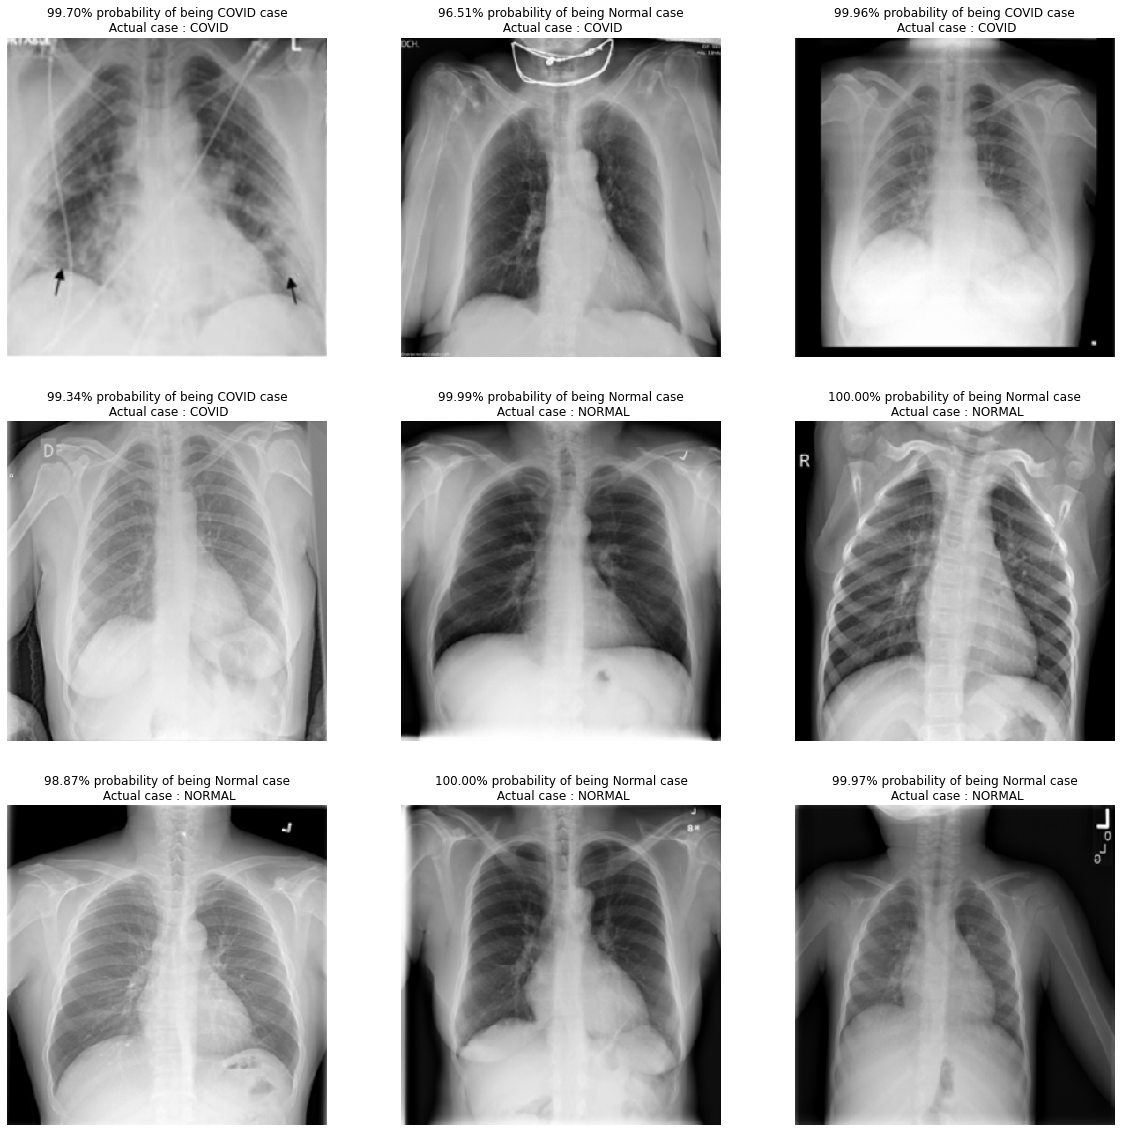

In [25]:
dic = {0:'COVID', 1:'NORMAL'}
plt.figure(figsize=(20,20))
for i in range(0+359, 9+359):
  plt.subplot(3, 3, (i-359)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Normal case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being COVID case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]),cmap='gray')
  plt.axis('off')
plt.show()